In [1]:
from kmeans import kmeans, test_kmeans
import numpy as np
import image_tools as im
from skimage import io
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.colors import ListedColormap

# load and pre-process data

In [2]:
# read data
u = io.imread(r'C:\Maha\DATA\dbh_activation_gfap_imaging_vnr\280923\binned_frames_replaced\F3_3s.tif').astype('float')
u=u[800:1200,:,:]
print(u.shape)
nt, ny, nx = u.shape
zoom = 2
#im.View(np.stack([np.kron(v,np.ones((zoom,zoom))) for v in u]))

(400, 128, 63)


In [3]:
output_path = r'C:\Maha\DATA\dbh_activation_gfap_imaging_vnr\280923\analysed\new\3s\F3'

C:\Users\m.dhanasekar\AppData\Local\Temp\ipykernel_37556\606211480.py:15: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(umax)


<Axes: ylabel='Density'>

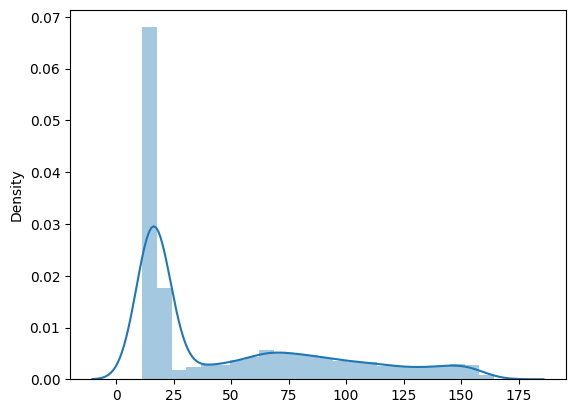

In [4]:
# subtract background
#bg = np.median(u, axis=0)
bg = np.min(u, axis=0)
us = u - bg
#im.View(im.zoom0(us,2), disp=['bg subtracted']*nt, cmap='nipy_spectral')

# temporal ~gaussian smoothing
for i in range(5):
    uss = us
    uss[1:-1] = (us[:-2]+us[1:-1]+us[2:])/3
    us = uss
# map of pixels with relative max >= activity_threshold
umax = np.max(us, axis=0)
#im.View(np.kron(umax, np.ones((2,2))), disp="max over time")
sns.distplot(umax)

In [5]:
activity_threshold =32
act0 = umax >= activity_threshold
im.View(im.zoom0(1*act0,2), disp='active pixels')

# see main activity period
umin = np.min(us, axis=0)
ubin = 1*((us-umin)>0.5*(umax-umin))
#im.View(ubin)

# consider temporal profile of active pixels only
act0xy = act0.reshape(nx*ny)
usxy = us.reshape((nt,nx*ny))
trajs = usxy[:,act0xy]
print(trajs.shape)

(400, 3552)


# K=5

In [6]:
# kmeans
k = 6
C0 = trajs[:,:k]
C,I = kmeans(trajs, C0, 1000) 

iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
iteration 10
iteration 11
iteration 12
iteration 13
iteration 14
iteration 15
iteration 16
iteration 17
iteration 18
iteration 19
iteration 20
iteration 21
iteration 22
iteration 23
iteration 24
iteration 25
iteration 26
iteration 27
iteration 28
iteration 29
iteration 30
iteration 31
iteration 32
iteration 33
iteration 34
iteration 35
iteration 36
iteration 37
iteration 38
iteration 39
iteration 40
kmeans converged after 41 iterations


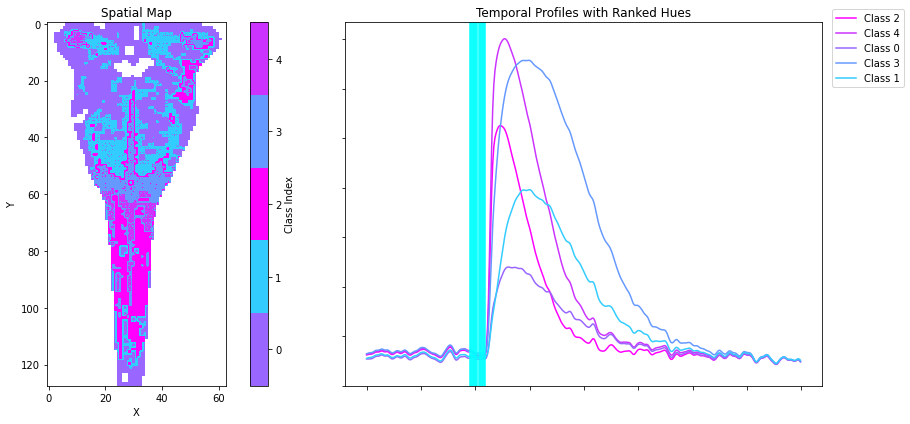

In [7]:
# Manually specify shades of red from darkest to lightest

red_shades = [
    (1.0, 0.0, 1.0),  # Hot Pink
    (0.8, 0.2, 1.0),
    (0.6, 0.4, 1.0),
    (0.4, 0.6, 1.0),
    (0.2, 0.8, 1.0),  # Blue
]

# find time_to_peak and amplitude for each class
time_to_peak = np.argmax(C, axis=0)
min_time_to_peak = min(time_to_peak)
max_time_to_peak = max(time_to_peak)
relative_time_to_peak = (time_to_peak-min_time_to_peak)/(max_time_to_peak-min_time_to_peak)

# Rank classes based on time-to-peak
ranked_classes = np.argsort(time_to_peak)

# Make sure red_shades has enough elements for the number of classes (k)
num_red_shades = len(red_shades)
red_shades = red_shades * (num_red_shades // k) + red_shades[:num_red_shades % k]

# Create a custom colormap with ranked shades of red
class_shades_mapping = dict(zip(ranked_classes, red_shades))
custom_cmap = ListedColormap([class_shades_mapping[class_idx] for class_idx in range(k)])


# Plot spatial map with the custom colormap
Ixy = np.zeros(nx * ny)
Ixy[act0xy] = I  
Ixy[~act0xy]=np.nan
Ixy = Ixy.reshape((ny, nx))

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

spatial_map = axes[0].imshow(Ixy, cmap=custom_cmap, vmin=0, vmax=k)
axes[0].set_title('Spatial Map')
axes[0].set_xlabel('X')
axes[0].set_ylabel('Y')
cbar = plt.colorbar(spatial_map, ax=axes[0], ticks=np.arange(0.5, k, 1), label='Class Index')
cbar.set_ticklabels(np.arange(0, k ))

# Plot temporal profiles with ranked hues on the right
for i in range(k):
    class_index = ranked_classes[i]
    axes[1].plot(C[:, class_index], color=class_shades_mapping[class_index], label=f'Class {class_index}')
    
# Add vertical lines for 15 frames for stim
for frames in range (95,110):
    axes[1].axvline(frames, color='cyan')

plt.xticks(color='w')
plt.yticks(color='w')
axes[1].legend(loc='upper left', bbox_to_anchor=(1.01, 1.05))
axes[1].set_title('Temporal Profiles with Ranked Hues')
axes[1].set_yticks(np.arange(0, axes[1].get_ylim()[1], 20))
plt.tight_layout()
plt.savefig(output_path + r'\K_5.png')
plt.savefig(output_path + r'\K_5.svg')
plt.show()


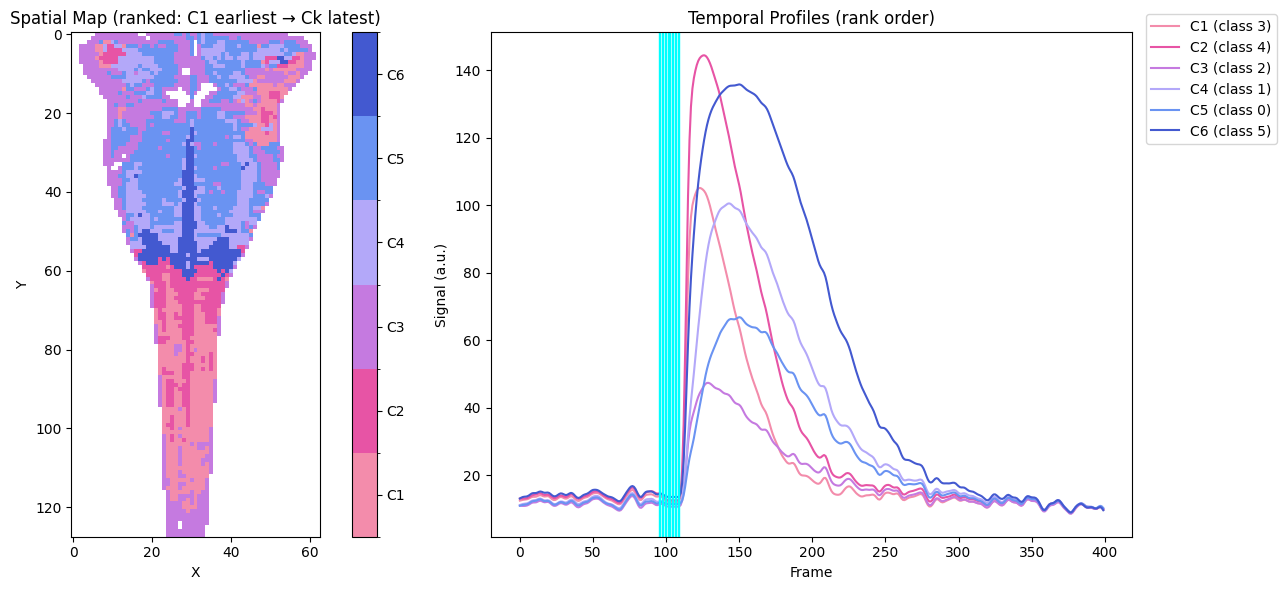

In [13]:
import numpy as np
from matplotlib.colors import ListedColormap, BoundaryNorm

# ---- final palette in rank order: C1..C6 ----
rank_hex = ["#F38CAB", "#E754A5", "#C57AE0", "#B3A8F9", "#6A93F2", "#4359D0"]

k = C.shape[1]  # number of classes (columns in C)
if k > len(rank_hex):
    raise ValueError(f"Palette has 6 colors but k={k}. Extend palette if needed.")
rank_colors = rank_hex[:k]

# 1) Compute rank: earliest time-to-peak first (C1), latest last (Ck)
time_to_peak = np.argmax(C, axis=0)          # shape (k,)
ranked_classes = np.argsort(time_to_peak)    # array of class indices sorted by TTP

# Map original class index -> rank id (1..k)
class_to_rank = {int(cls): (int(rank)+1) for rank, cls in enumerate(ranked_classes)}  # e.g., class 3 -> C1 (rank=1)

# 2) Build a rank-labeled image (Ixy_rank: 1..k), keeping background as NaN
Ixy = np.zeros(nx * ny, dtype=float)
Ixy[act0xy] = I  # I contains original class indices
Ixy[~act0xy] = np.nan
Ixy = Ixy.reshape((ny, nx))

Ixy_rank = np.full_like(Ixy, np.nan, dtype=float)
# remap each class id to its rank id
for cls, rnk in class_to_rank.items():
    Ixy_rank[Ixy == cls] = rnk  # now values are 1..k

# 3) Discrete colormap in rank order C1..Ck
rank_cmap = ListedColormap(rank_colors).copy()
rank_cmap.set_bad(alpha=0.0)  # NaNs transparent

bounds = np.arange(0.5, k + 1.5, 1)        # centers at 1..k
norm = BoundaryNorm(bounds, rank_cmap.N)

# 4) Plot spatial map using rank labels (so C1 is ALWAYS pink)
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

im = axes[0].imshow(np.ma.masked_invalid(Ixy_rank), cmap=rank_cmap, norm=norm, interpolation='nearest')
axes[0].set_title('Spatial Map (ranked: C1 earliest → Ck latest)')
axes[0].set_xlabel('X'); axes[0].set_ylabel('Y')

# colorbar shows C1..Ck in order
cbar = plt.colorbar(im, ax=axes[0], boundaries=bounds, ticks=np.arange(1, k+1))
cbar.set_ticklabels([f'C{i}' for i in range(1, k+1)])

# 5) Temporal profiles: plot in rank order with matching colors & labels
for rank_idx, cls in enumerate(ranked_classes, start=1):
    axes[1].plot(C[:, cls], color=rank_colors[rank_idx-1], label=f'C{rank_idx} (class {cls})')

# stim window
for fr in range(95, 110):
    axes[1].axvline(fr, color='cyan', linewidth=1)

axes[1].legend(loc='upper left', bbox_to_anchor=(1.01, 1.05))
axes[1].set_title('Temporal Profiles (rank order)')
axes[1].set_xlabel('Frame'); axes[1].set_ylabel('Signal (a.u.)')

plt.tight_layout()
plt.savefig(output_path + r'\K_6_ranked.svg', bbox_inches='tight')
plt.show()





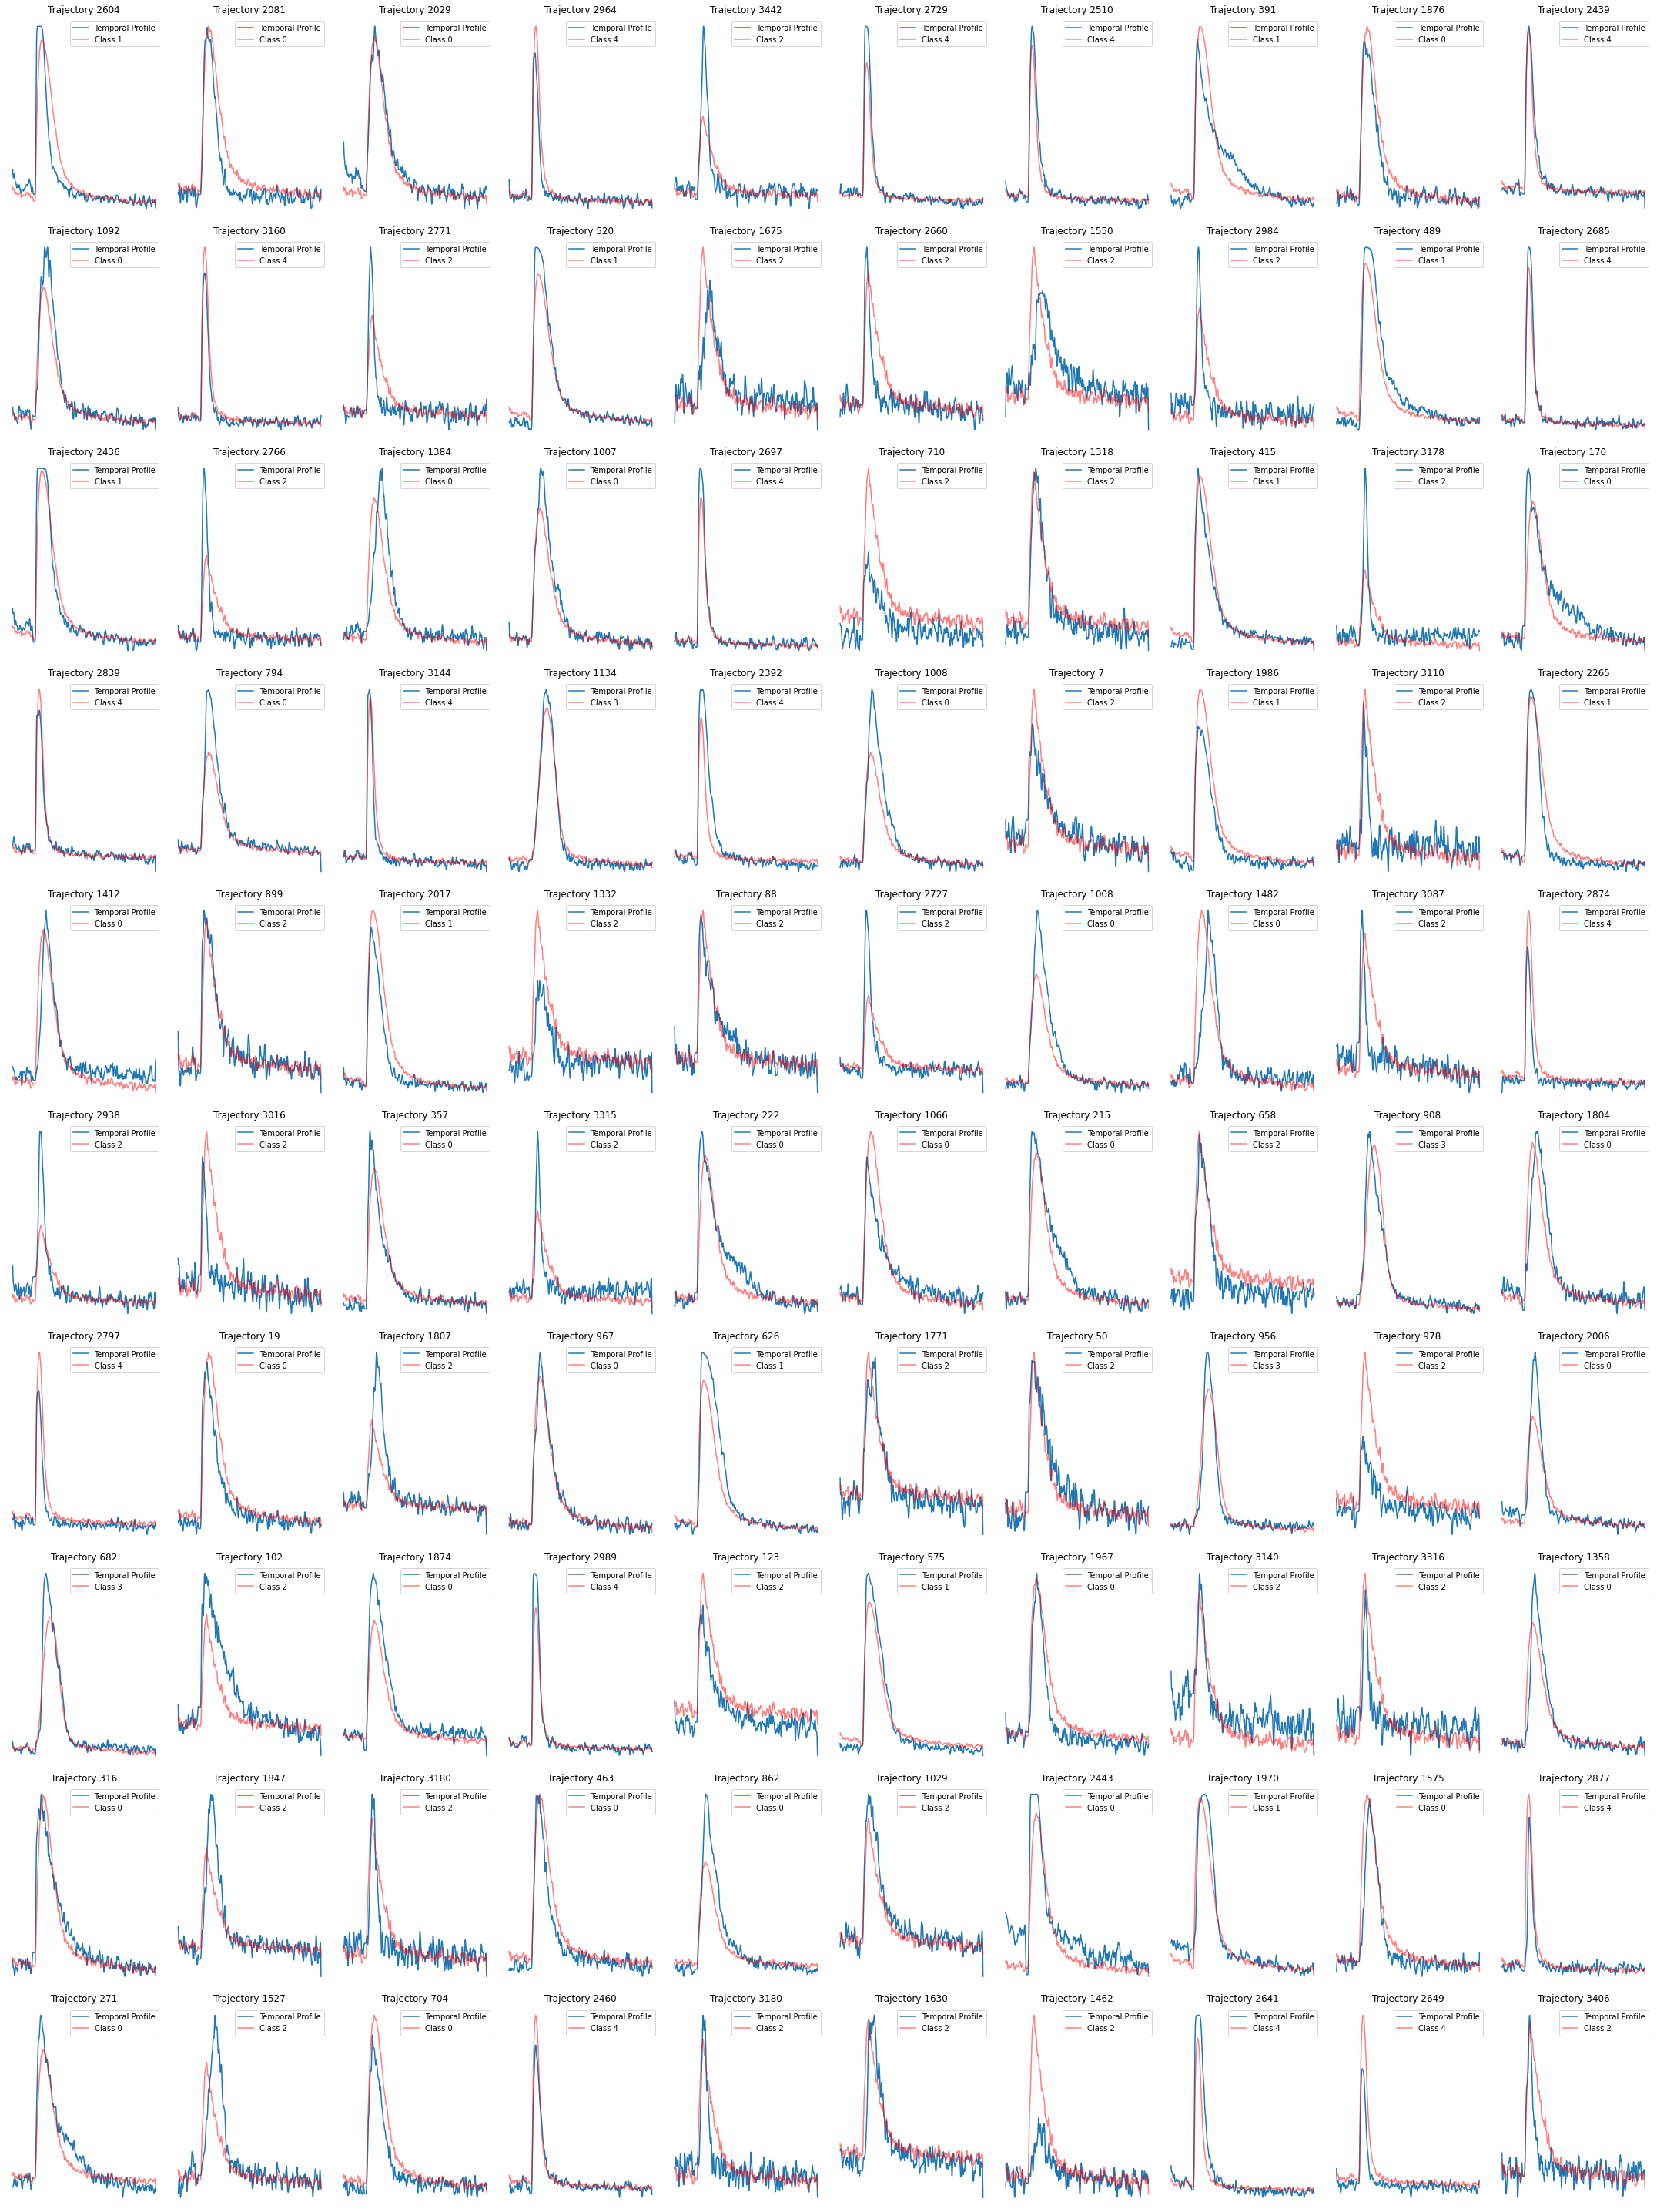

In [128]:
import random
num_pixels = 100
fig, axes = plt.subplots(10, 10, figsize=(30, 40))

for ax in axes.flatten():
    # Randomly select a pixel
    i = random.randrange(trajs.shape[1])
    
    # Plot the temporal profile
    ax.plot(trajs[:, i], label='Temporal Profile')

    # Plot the profile of the corresponding class in red
    c = I[i]
    ax.plot(C[:, c], 'r', label=f'Class {c}',alpha=0.5)
    ax.set_title(f'Trajectory {i}')
    ax.legend()
    ax.axis('off')

plt.tight_layout()

plt.savefig(output_path + r'\random_pixel_check.png')
# Show the figure
plt.show()

# K =10

In [145]:
# kmeans
k = 10
C0 = trajs[:,:k]
C,I = kmeans(trajs, C0, 1000) 


iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
iteration 10
iteration 11
iteration 12
iteration 13
iteration 14
iteration 15
iteration 16
iteration 17
iteration 18
iteration 19
iteration 20
iteration 21
iteration 22
iteration 23
iteration 24
iteration 25
iteration 26
iteration 27
iteration 28
iteration 29
iteration 30
iteration 31
iteration 32
iteration 33
iteration 34
iteration 35
iteration 36
iteration 37
iteration 38
iteration 39
iteration 40
iteration 41
kmeans converged after 42 iterations


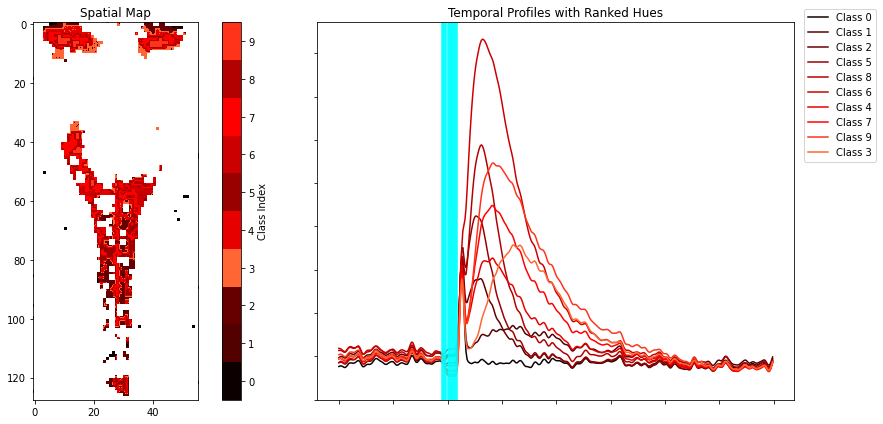

In [146]:
red_shades = [
    (0.05, 0, 0),
    (0.32, 0, 0),
    (0.4, 0, 0),
    (0.6, 0, 0),
    (0.7, 0, 0),
    (0.8, 0, 0),
    (0.9, 0, 0),
    (1.0, 0, 0),
    (1.0, 0.2, 0.1),
    (1.0, 0.4, 0.2),
]

# find and rank time_to_peak of each class
time_to_peak = np.argmax(C, axis=0)
min_time_to_peak = min(time_to_peak)
max_time_to_peak = max(time_to_peak)
relative_time_to_peak = (time_to_peak-min_time_to_peak)/(max_time_to_peak-min_time_to_peak)
ranked_classes = np.argsort(time_to_peak)

num_red_shades = len(red_shades)
red_shades = red_shades * (num_red_shades // k) + red_shades[:num_red_shades % k]# check for matching elements for the number of classes (k)

# Create a custom colormap with ranked shades of red
class_shades_mapping = dict(zip(ranked_classes, red_shades))
custom_cmap = ListedColormap([class_shades_mapping[class_idx] for class_idx in range(k)])

# Plot spatial map with the custom colormap

fig, axes = plt.subplots(1, 2, figsize=(15, 6))
Ixy = np.zeros(nx * ny)
Ixy[act0xy] = I  
Ixy[~act0xy]=np.nan
Ixy = Ixy.reshape((ny, nx))

spatial_map = axes[0].imshow(Ixy, cmap=custom_cmap, vmin=0, vmax=k)
axes[0].set_title('Spatial Map')
cbar = plt.colorbar(spatial_map, ax=axes[0], ticks=np.arange(0.5, k, 1), label='Class Index')
cbar.set_ticklabels(np.arange(0, k ))

# Plot temporal profiles with ranked hues on the right
for i in range(k):
    class_index = ranked_classes[i]
    axes[1].plot(C[:, class_index], color=class_shades_mapping[class_index], label=f'Class {class_index}')
    
for frames in range (95,110):
    axes[1].axvline(frames, color='cyan')# Add vertical lines for 15 stim frames

plt.xticks(color='w')
plt.yticks(color='w')
axes[1].legend(loc='upper left', bbox_to_anchor=(1.01, 1.05))
axes[1].set_title('Temporal Profiles with Ranked Hues')
axes[1].set_yticks(np.arange(0, axes[1].get_ylim()[1], 20))
plt.tight_layout()
plt.savefig(output_path + r'\K_10.png')
plt.savefig(output_path + r'\K_10.svg')
plt.show()

# K=15

In [147]:
# kmeans
k = 15
C0 = trajs[:,:k]
C,I = kmeans(trajs, C0, 1000) 


iteration 1
iteration 2
iteration 3
iteration 4
iteration 5
iteration 6
iteration 7
iteration 8
iteration 9
iteration 10
iteration 11
iteration 12
iteration 13
iteration 14
iteration 15
iteration 16
iteration 17
iteration 18
iteration 19
iteration 20
iteration 21
iteration 22
iteration 23
iteration 24
iteration 25
iteration 26
iteration 27
iteration 28
iteration 29
iteration 30
iteration 31
iteration 32
kmeans converged after 33 iterations


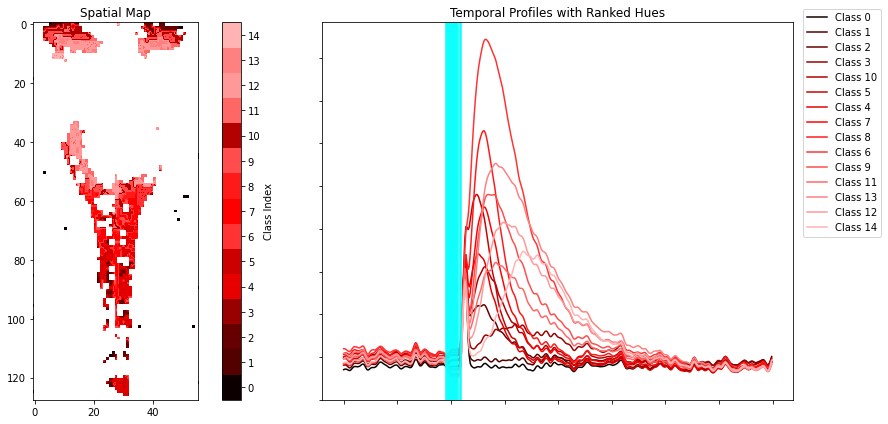

In [148]:

red_shades = [
    (0.05, 0, 0),
    (0.32, 0, 0),
    (0.4, 0, 0),
    (0.6, 0, 0),
    (0.7, 0, 0),
    (0.8, 0, 0),
    (0.9, 0, 0),
    (1.0, 0, 0),
    (1.0, 0.1, 0.1),
    (1.0, 0.2, 0.2),
    (1.0, 0.3, 0.3),
    (1.0, 0.4, 0.4),
    (1.0, 0.5, 0.5),
    (1.0, 0.6, 0.6),
    (1.0, 0.7, 0.7),
]


# find and rank time_to_peak of each class
time_to_peak = np.argmax(C, axis=0)
min_time_to_peak = min(time_to_peak)
max_time_to_peak = max(time_to_peak)
relative_time_to_peak = (time_to_peak-min_time_to_peak)/(max_time_to_peak-min_time_to_peak)
ranked_classes = np.argsort(time_to_peak)

num_red_shades = len(red_shades)
red_shades = red_shades * (num_red_shades // k) + red_shades[:num_red_shades % k]# check for matching elements for the number of classes (k)

# Create a custom colormap with ranked shades of red
class_shades_mapping = dict(zip(ranked_classes, red_shades))
custom_cmap = ListedColormap([class_shades_mapping[class_idx] for class_idx in range(k)])

# Plot spatial map with the custom colormap

fig, axes = plt.subplots(1, 2, figsize=(15, 6))
Ixy = np.zeros(nx * ny)
Ixy[act0xy] = I  
Ixy[~act0xy]=np.nan
Ixy = Ixy.reshape((ny, nx))

spatial_map = axes[0].imshow(Ixy, cmap=custom_cmap, vmin=0, vmax=k)
axes[0].set_title('Spatial Map')
cbar = plt.colorbar(spatial_map, ax=axes[0], ticks=np.arange(0.5, k, 1), label='Class Index')
cbar.set_ticklabels(np.arange(0, k ))

# Plot temporal profiles with ranked hues on the right
for i in range(k):
    class_index = ranked_classes[i]
    axes[1].plot(C[:, class_index], color=class_shades_mapping[class_index], label=f'Class {class_index}')
    
for frames in range (95,110):
    axes[1].axvline(frames, color='cyan')# Add vertical lines for 15 stim frames

plt.xticks(color='w')
plt.yticks(color='w')
axes[1].legend(loc='upper left', bbox_to_anchor=(1.01, 1.05))
axes[1].set_title('Temporal Profiles with Ranked Hues')
axes[1].set_yticks(np.arange(0, axes[1].get_ylim()[1], 20))
plt.tight_layout()
plt.savefig(output_path + r'\K_15.png')
plt.savefig(output_path + r'\K_15.svg')
plt.show()

In [ ]:
# manually assign red shades
red_shades = [
    (0.05, 0, 0),
    (0.32, 0, 0),
    (0.4, 0, 0),
    (0.6, 0, 0),
    (0.7, 0, 0),
    (0.8, 0, 0),
    (0.9, 0, 0),
    (1.0, 0, 0),
    (1.0, 0.1, 0.1),
    (1.0, 0.2, 0.2),
    (1.0, 0.3, 0.3),
    (1.0, 0.4, 0.4),
    (1.0, 0.5, 0.5),
    (1.0, 0.6, 0.6),
    (1.0, 0.7, 0.7),
]
